### Imports

In [114]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import umap
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import Dict, List, Any, Tuple, Optional

### Clinical Data Preprocessing

In [115]:
def parse_dt(dt_str: Optional[str]) -> Optional[datetime.datetime]:
    if dt_str is None:
        return None
    try:
        return datetime.datetime.fromisoformat(dt_str)
    except Exception:
        return None

def safe_min(values):
    vals = [v for v in values if v is not None and not pd.isna(v)]
    return min(vals) if vals else None

def safe_max(values):
    vals = [v for v in values if v is not None and not pd.isna(v)]
    return max(vals) if vals else None

def aggregate_patient(patient: Dict[str, Any]) -> Dict[str, Any]:
    """
    Aggregate a single TCGA-GBM-style patient JSON into flat features.
    """
    out: Dict[str, Any] = {"submitter_id": patient.get("submitter_id")}

    # Survival outcome data
    demo = patient.get("demographic", {}) or {}
    vital_status = demo.get("vital_status")
    days_to_death = demo.get("days_to_death")
    days_to_last_follow_up = None

    diagnoses = patient.get("diagnoses", []) or []
    for d in diagnoses:
        if d.get("days_to_last_follow_up") is not None:
            days_to_last_follow_up = d.get("days_to_last_follow_up")
            break

    if vital_status == "Dead" and days_to_death is not None:
        time = float(days_to_death)
        event = 1
    else:
        time = float(days_to_last_follow_up) if days_to_last_follow_up is not None else np.nan
        event = 0

    out["survival_time"] = time
    # out["vital_status"] = event # 1 if dead, 0 if alive

    # Demographic data
    out["age_at_index"] = demo.get("age_at_index")
    out["sex_at_birth"] = demo.get("sex_at_birth")
    out["race"] = demo.get("race")
    out["ethnicity"] = demo.get("ethnicity")

    # Diagnoses: choose “final baseline” diagnosis and track progression
    diag_records = []
    for d in diagnoses:
        days_to_diag = d.get("days_to_diagnosis")
        cdt = parse_dt(d.get("created_datetime"))
        udt = parse_dt(d.get("updated_datetime"))
        diag_records.append((d, days_to_diag, cdt, udt))

    diag_records.sort(key=lambda x: (
        float("inf") if x[1] is None else x[1],
        datetime.datetime.min if x[2] is None else x[2],
        datetime.datetime.min if x[3] is None else x[3],
    ))

    # Separate primary-like vs progression-like
    primary_like = []
    progression_like = []

    for d, dt_d, cdt, udt in diag_records:
        cl = (d.get("classification_of_tumor") or "").lower()
        if cl in ("primary", "initial diagnosis", ""):
            primary_like.append((d, dt_d, cdt, udt))
        elif cl in ("progression", "recurrence"):
            progression_like.append((d, dt_d, cdt, udt))
        else:
            progression_like.append((d, dt_d, cdt, udt))

    # Final baseline (most specific, latest among primary-like; fallback to earliest diag)
    if primary_like:
        # take latest in time among primary_like
        primary_like.sort(key=lambda x: (
            float("-inf") if x[1] is None else x[1],
            datetime.datetime.min if x[2] is None else x[2],
            datetime.datetime.min if x[3] is None else x[3],
        ), reverse=True)
        base_diag = primary_like[0][0]
    elif diag_records:
        base_diag = diag_records[0][0]
    else:
        base_diag = {}

    out["primary_site"] = patient.get("primary_site")
    out["project_id"] = patient.get("project", {}).get("project_id")

    out["baseline_primary_diagnosis"] = base_diag.get("primary_diagnosis")
    out["baseline_morphology"] = base_diag.get("morphology")
    out["baseline_icd10"] = base_diag.get("icd_10_code")
    out["baseline_classification"] = base_diag.get("classification_of_tumor")
    out["baseline_year_of_diagnosis"] = base_diag.get("year_of_diagnosis")
    out["baseline_age_at_diagnosis"] = base_diag.get("age_at_diagnosis")

    # Progression diagnoses (optional; you can drop if you rely on follow_ups only)
    prog_days = [
        rec[1] for rec in progression_like
        if rec[1] is not None
    ]
    out["num_progression_diagnoses"] = len(prog_days)
    out["diag_days_to_first_progression"] = safe_min(prog_days) if prog_days else np.nan

    # Disease course and performance status data
    follow_ups = patient.get("follow_ups", []) or []

    days_to_progression_list = []
    kps_values = []

    for f in follow_ups:
        prog_flag = f.get("progression_or_recurrence")
        days_to_prog = f.get("days_to_progression")
        if prog_flag == "Yes" and days_to_prog is not None:
            days_to_progression_list.append(days_to_prog)

        kps = f.get("karnofsky_performance_status")
        if kps is not None and kps != "Unknown":
            kps_values.append(float(kps))

    # First progression from follow-up data
    out["first_progression"] = 1 if days_to_progression_list else 0
    out["days_to_first_progression"] = float(min(days_to_progression_list)) if days_to_progression_list else np.nan
    out["num_progression_events"] = len(days_to_progression_list) if days_to_progression_list else 0

    out["kps_min"] = safe_min(kps_values)
    out["kps_max"] = safe_max(kps_values)
    out["kps_mean"] = float(np.mean(kps_values)) if kps_values else np.nan

    # Treatment summary data
    all_treatments = []
    for d in diagnoses:
        for t in d.get("treatments", []) or []:
            all_treatments.append(t)

    def any_treat(filter_fn):
        return any(filter_fn(t) for t in all_treatments) # True if a given treatment was performed, False otherwise

    def earliest_start(filter_fn):
        vals = [
            t.get("days_to_treatment_start")
            for t in all_treatments
            if filter_fn(t) and t.get("days_to_treatment_start") is not None
        ]
        return safe_min(vals)

    def total_dose(filter_fn):
        vals = [
            t.get("treatment_dose")
            for t in all_treatments
            if filter_fn(t) and t.get("treatment_dose") is not None
        ]
        return float(np.nansum(vals)) if vals else np.nan

    def is_surgery(t):
        return "surgery" in (t.get("treatment_type") or "").lower()

    def is_radiation(t):
        return "radiation" in (t.get("treatment_type") or "").lower()

    def is_chemo(t):
        return "chemo" in (t.get("treatment_type") or "").lower()

    def is_dexamethasone(t):
        agents = (t.get("therapeutic_agents") or "").lower()
        return "dexamethasone" in agents

    out["any_surgery"] = int(any_treat(is_surgery))
    out["days_to_first_surgery"] = earliest_start(is_surgery)
    out["any_radiation"] = int(any_treat(is_radiation))
    out["days_to_first_radiation"] = earliest_start(is_radiation)

    rt_doses = [
        t.get("treatment_dose")
        for t in all_treatments
        if is_radiation(t) and t.get("treatment_dose") is not None
    ]
    rt_fracs = [
        t.get("number_of_fractions")
        for t in all_treatments
        if is_radiation(t) and t.get("number_of_fractions") is not None
    ]

    out["rt_total_dose"] = float(np.nansum(rt_doses)) if rt_doses else np.nan
    out["rt_total_fractions"] = float(np.nansum(rt_fracs)) if rt_fracs else np.nan

    out["any_chemo"] = int(any_treat(is_chemo))
    out["days_to_first_chemo"] = earliest_start(is_chemo)
    out["chemo_total_dose"] = total_dose(is_chemo)

    out["any_dexamethasone"] = int(any_treat(is_dexamethasone))
    out["days_to_first_dexamethasone"] = earliest_start(is_dexamethasone)

    return out, time, event

def aggregate_cohort(patients: List[Dict[str, Any]]) -> pd.DataFrame:
    features_list = []
    labels_dict = {}

    for p in patients:
        features, survival_time, survival_event = aggregate_patient(p)
        features_list.append(features)

        pid = p.get("submitter_id")
        if pd.notna(survival_time):
            labels_dict[pid] = (survival_time, survival_event)

    df = pd.DataFrame(features_list)
    nunique = df.nunique(dropna=False)
    constant_cols = nunique[nunique <= 1].index.tolist()
    df = df.drop(columns=constant_cols)

    return df, labels_dict

class ClinicalDataProcessor:
    """
    Processes clinical data from TCGA-style JSON into model-ready format
    """

    def __init__(self,
                 categorical_threshold: int = 10,
                 imputation_strategy: str = 'median',
                 normalize_numerical: bool = True):
        """
        Args:
            categorical_threshold: Max unique values for a column to be treated as categorical
            imputation_strategy: 'mean', 'median', or 'most_frequent'
            normalize_numerical: Whether to standardize numerical features
        """
        self.categorical_threshold = categorical_threshold
        self.imputation_strategy = imputation_strategy
        self.normalize_numerical = normalize_numerical
        self.preprocessor = None
        self.feature_names = None
        self.numerical_cols = None
        self.categorical_cols = None
        self.id_col = 'submitter_id'

    def _identify_column_types(self, df: pd.DataFrame) -> Tuple[List[str], List[str]]:
        numerical_cols = []
        categorical_cols = []

        for col in df.columns:
            if col == self.id_col:
                continue

            if pd.api.types.is_numeric_dtype(df[col]):
                # Check if actually categorical despite numeric dtype
                unique_vals = df[col].nunique(dropna=True)
                if unique_vals <= self.categorical_threshold and unique_vals > 1:
                    categorical_cols.append(col)
                else:
                    numerical_cols.append(col)
            else:
                categorical_cols.append(col)

        return numerical_cols, categorical_cols

    def preprocess_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        processed = df.copy()
        ids = processed[self.id_col].reset_index(drop=True)
        processed = processed.drop(columns=[self.id_col])
        self.numerical_cols, self.categorical_cols = self._identify_column_types(processed)

        for col in self.categorical_cols:
            processed[col] = processed[col].astype(str).replace('nan', 'missing')

        for col in self.numerical_cols:
            processed[col] = pd.to_numeric(processed[col], errors='coerce')
            processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)

        transformers = []
        if self.numerical_cols:
            num_pipeline_steps = [
                ('imputer', SimpleImputer(strategy=self.imputation_strategy))
            ]
            if self.normalize_numerical:
                num_pipeline_steps.append(('scaler', StandardScaler()))

            num_pipeline = Pipeline(num_pipeline_steps)
            transformers.append(('num', num_pipeline, self.numerical_cols))

        if self.categorical_cols:
            cat_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers.append(('cat', cat_pipeline, self.categorical_cols))

        self.preprocessor = ColumnTransformer(transformers, remainder='drop')
        processed_array = self.preprocessor.fit_transform(processed)
        self.feature_names = []

        if self.numerical_cols:
            if self.normalize_numerical:
                self.feature_names.extend(self.numerical_cols)
            else:
                self.feature_names.extend([f"{col}_imputed" for col in self.numerical_cols])

        if self.categorical_cols:
            cat_transformer = self.preprocessor.named_transformers_['cat']
            encoder = cat_transformer.named_steps['encoder']

            encoded_names = encoder.get_feature_names_out(self.categorical_cols)
            self.feature_names.extend(encoded_names)

        result_df = pd.DataFrame(processed_array, columns=self.feature_names)
        result_df[self.id_col] = ids
        cols = [self.id_col] + [c for c in result_df.columns if c != self.id_col]
        result_df = result_df[cols]

        return result_df

    def transform_new_data(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.preprocessor is None:
            raise ValueError("Preprocessor not fitted. Call preprocess_dataframe first.")

        processed = df.copy()
        ids = processed[self.id_col].reset_index(drop=True)
        processed = processed.drop(columns=[self.id_col])

        for col in self.categorical_cols:
            if col in processed.columns:
                processed[col] = processed[col].astype(str).replace('nan', 'missing')

        for col in self.numerical_cols:
            if col in processed.columns:
                processed[col] = pd.to_numeric(processed[col], errors='coerce')
                processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)

        processed_array = self.preprocessor.transform(processed)

        result_df = pd.DataFrame(processed_array, columns=self.feature_names)
        result_df[self.id_col] = ids
        cols = [self.id_col] + [c for c in result_df.columns if c != self.id_col]
        result_df = result_df[cols]

        return result_df

    def build_feature_mapping(self, df: pd.DataFrame) -> Tuple[Dict[str, np.ndarray], List[str]]:
        if self.id_col not in df.columns:
            raise ValueError(f"DataFrame must contain '{self.id_col}' column")

        mapping = {}
        for idx, row in df.iterrows():
            patient_id = row[self.id_col]
            features = row.drop(self.id_col).astype(float).to_numpy()
            mapping[patient_id] = features

        return mapping, self.feature_names

    def save_processor(self, filepath: str):
        with open(filepath, 'wb') as f:
            pickle.dump({
                'preprocessor': self.preprocessor,
                'feature_names': self.feature_names,
                'numerical_cols': self.numerical_cols,
                'categorical_cols': self.categorical_cols,
                'id_col': self.id_col,
                'params': {
                    'categorical_threshold': self.categorical_threshold,
                    'imputation_strategy': self.imputation_strategy,
                    'normalize_numerical': self.normalize_numerical
                }
            }, f)

    @classmethod
    def load_processor(cls, filepath: str) -> 'ClinicalDataProcessor':
        """Load a fitted processor"""
        with open(filepath, 'rb') as f:
            saved = pickle.load(f)

        processor = cls(**saved['params'])
        processor.preprocessor = saved['preprocessor']
        processor.feature_names = saved['feature_names']
        processor.numerical_cols = saved['numerical_cols']
        processor.categorical_cols = saved['categorical_cols']
        processor.id_col = saved['id_col']

        return processor

def process_clinical_data(patient_json_list: List[Dict[str, Any]],
                          output_dir: str = "data",
                          save_intermediate: bool = True) -> Dict[str, np.ndarray]:
    os.makedirs(output_dir, exist_ok=True)
    df_raw, survival_labels = aggregate_cohort(patient_json_list)

    if save_intermediate:
        df_raw.to_csv(f"{output_dir}/clinical_raw.csv", index=False)
        with open(f"{output_dir}/survival_labels.pkl", "wb") as f:
            pickle.dump(survival_labels, f)

    processor = ClinicalDataProcessor(
        categorical_threshold=10,
        imputation_strategy='median',
        normalize_numerical=True
    )

    df_processed = processor.preprocess_dataframe(df_raw)
    feature_mapping, feature_names = processor.build_feature_mapping(df_processed)

    with open(f"{output_dir}/clinical_map.pkl", "wb") as f:
        pickle.dump({
            "mapping": feature_mapping,
            "feature_names": feature_names,
            "patient_ids": list(feature_mapping.keys()),
            "n_features": len(feature_names)
        }, f)

    with open(f"{output_dir}/survival_labels.pkl", "wb") as f:
        pickle.dump(survival_labels, f)
    processor.save_processor(f"{output_dir}/clinical_processor.pkl")
    df_processed.to_csv(f"{output_dir}/clinical_processed.csv", index=False)

    feature_summary = pd.DataFrame({
        'feature_name': feature_names,
        'feature_type': ['numerical' if name in processor.numerical_cols
                        else 'categorical_encoded' for name in feature_names]
    })
    feature_summary.to_csv(f"{output_dir}/clinical_features.csv", index=False)
    return feature_mapping, survival_labels

In [116]:
with open("C:/Users/amiya/PycharmProjects/mlcb/clinical.project-tcga-gbm.2025-11-26.json", "r") as f:
    patient_json_list = json.load(f)

# Process the data
clinical_mapping, survival_labels = process_clinical_data(patient_json_list, output_dir="data")

### Testing

QUICK QUALITY CHECK
----------------------------------------
PASS: Valid matrix
PASS: No NaN values
PASS: Feature count (77)
PASS: Value range (39.19)
PASS: Feature names

All checks passed! Embeddings look ready for model integration.


Running full diagnostic analysis...
Loading clinical embeddings...
Loaded 617 patients with 77 features
Loaded survival labels: 596 patients

CLINICAL EMBEDDINGS DIAGNOSTIC REPORT
BASIC EMBEDDING STATISTICS
Shape                         : 617 patients × 77 features
Sparsity (%)                  : 61.0
NaN values                    : 0
Mean ± Std                    : 0.208 ± 0.589
Min/Max                       : [-15.438, 23.750]
Feature correlation (mean)    : 0.115
Constant features             : 0


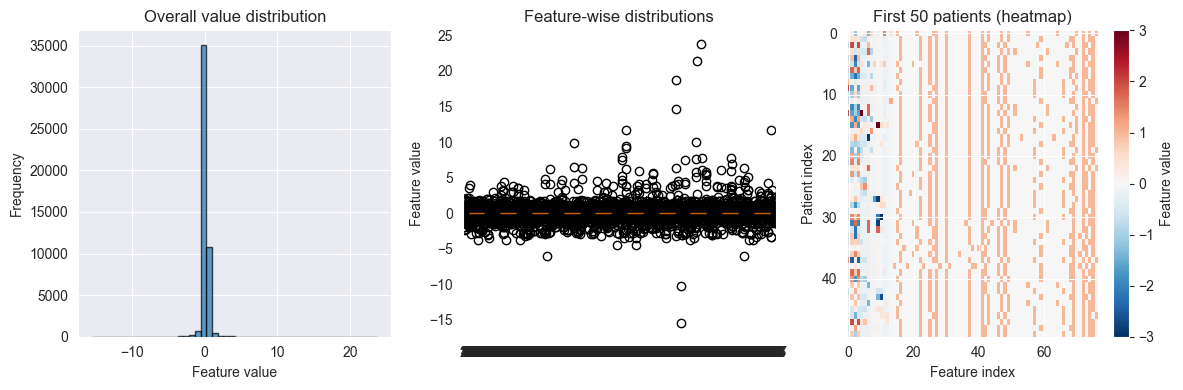


VISUALIZING EMBEDDINGS
Survival data: 491 events, 126 censored


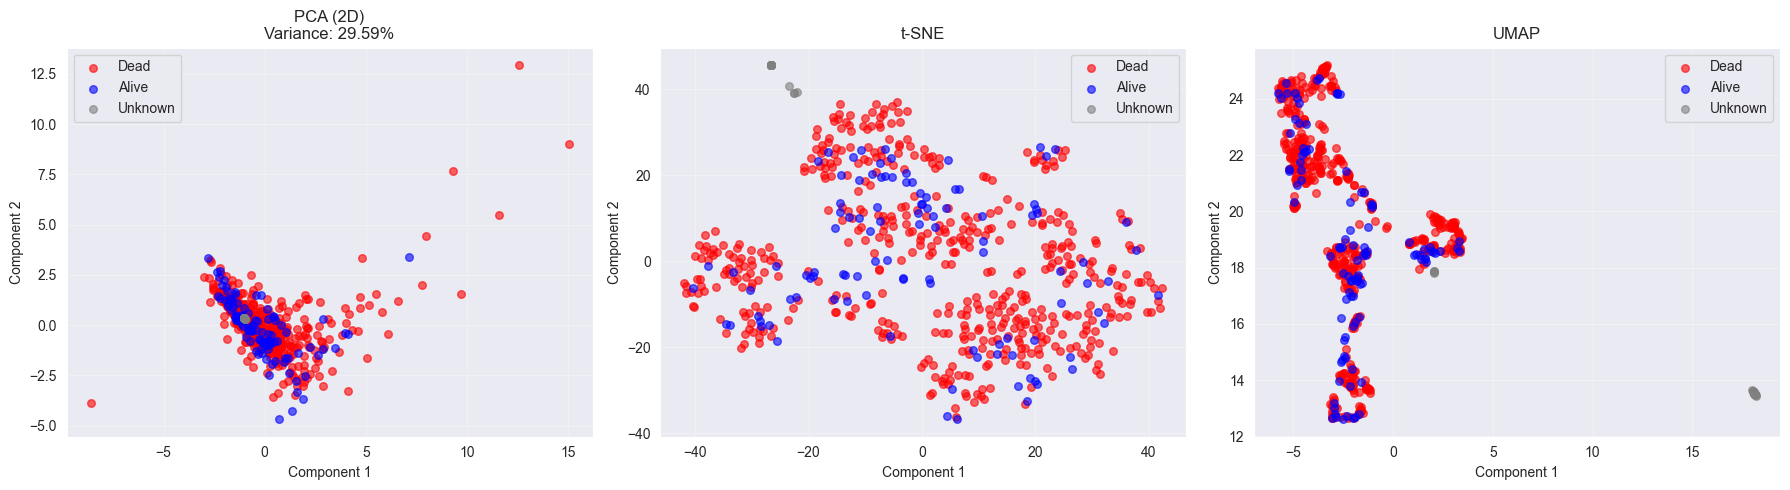

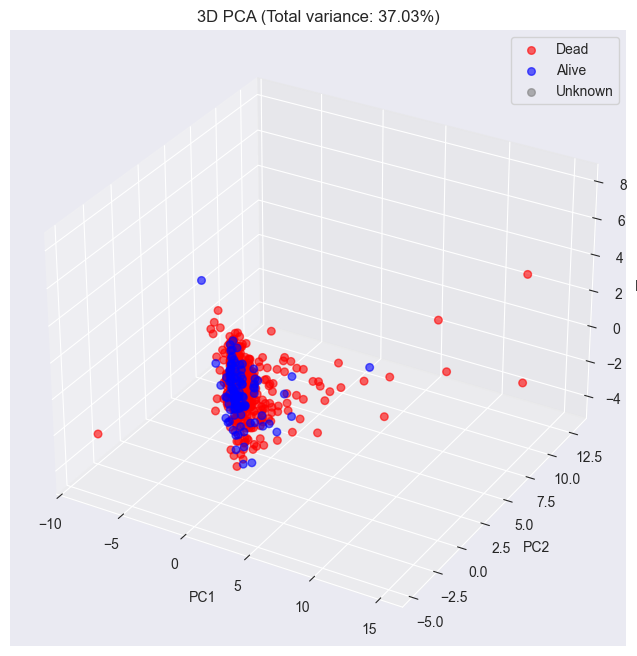


CLUSTER ANALYSIS


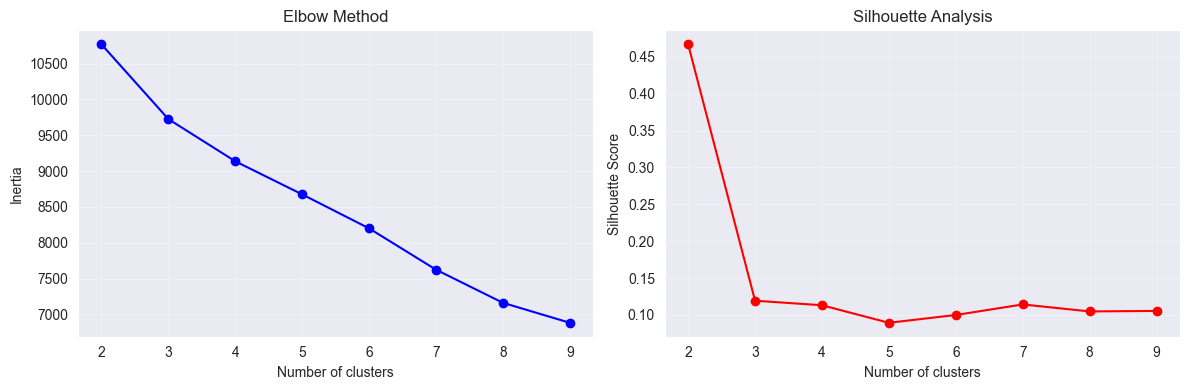

Optimal clusters (silhouette): 2


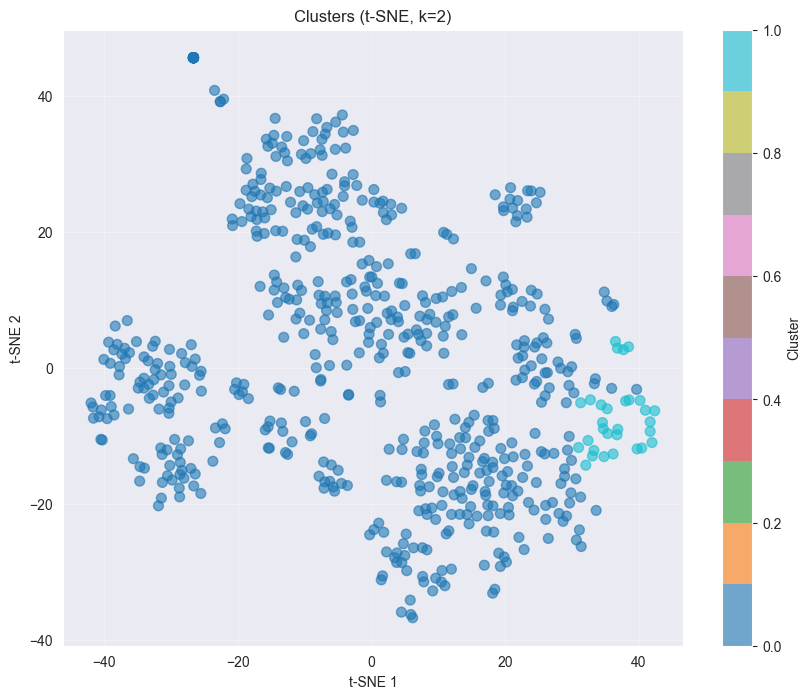


Cluster sizes:
  Cluster 0: 587 patients (95.1%)
  Cluster 1: 30 patients (4.9%)

Silhouette score: 0.467
Calinski-Harabasz score: 72.2

FEATURE IMPORTANCE ANALYSIS


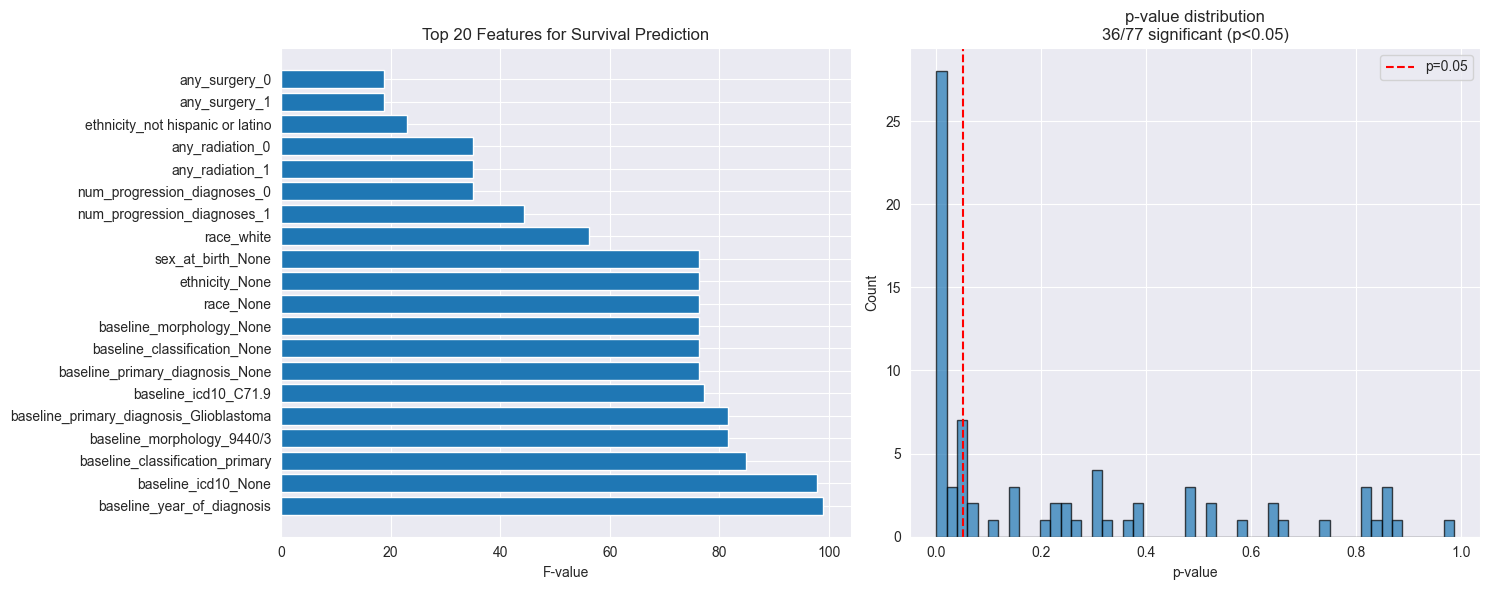


Survival-related features:
Significant features (p<0.05): 36/77

Top 10 survival-associated features:
  baseline_year_of_diagnosis                         F= 99.00, p=9.99e-22
  baseline_icd10_None                                F= 97.88, p=1.62e-21
  baseline_classification_primary                    F= 84.95, p=4.80e-19
  baseline_morphology_9440/3                         F= 81.57, p=2.17e-18
  baseline_primary_diagnosis_Glioblastoma            F= 81.57, p=2.17e-18
  baseline_icd10_C71.9                               F= 77.28, p=1.48e-17
  baseline_primary_diagnosis_None                    F= 76.33, p=2.27e-17
  baseline_classification_None                       F= 76.33, p=2.27e-17
  baseline_morphology_None                           F= 76.33, p=2.27e-17
  race_None                                          F= 76.33, p=2.27e-17

CORRELATION STRUCTURE


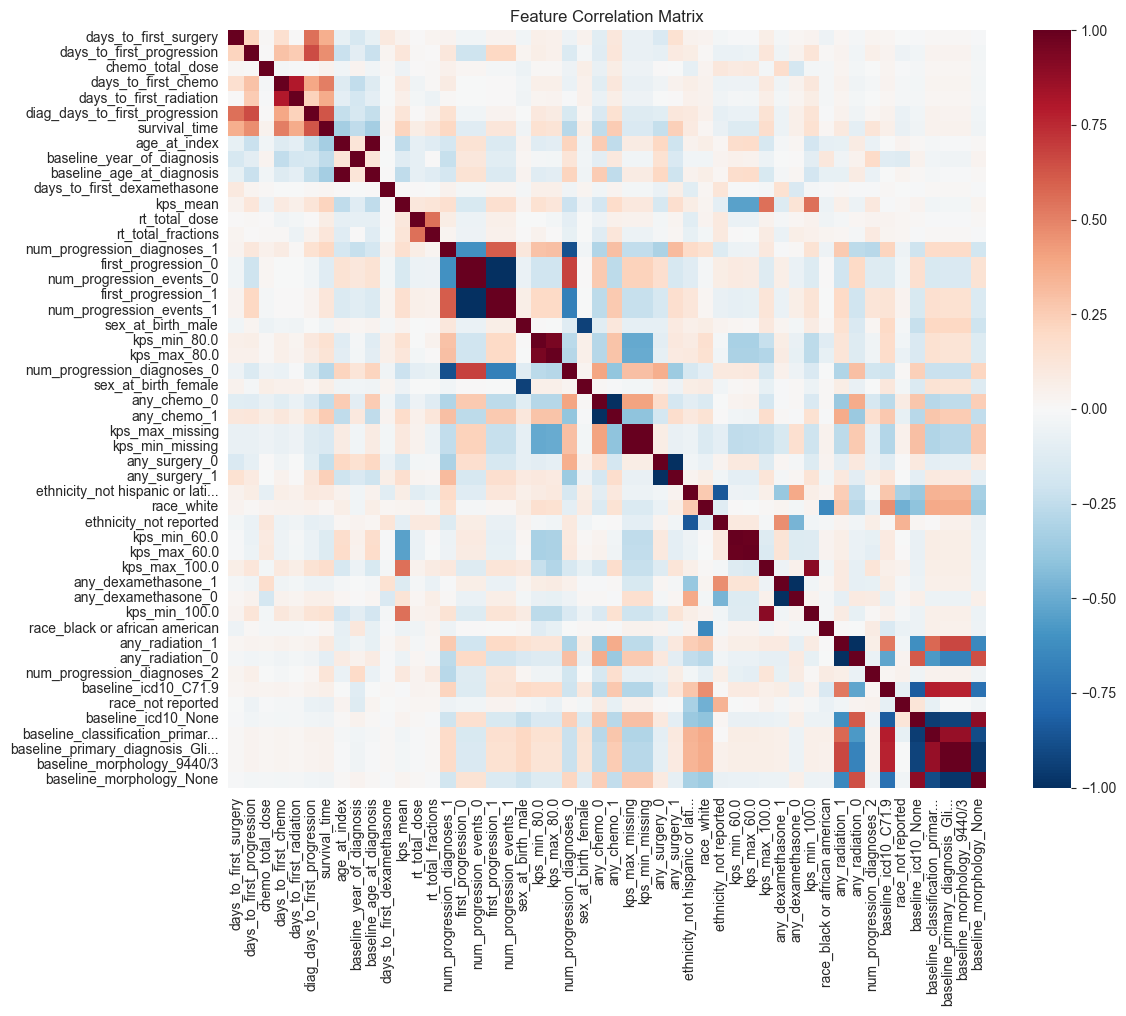

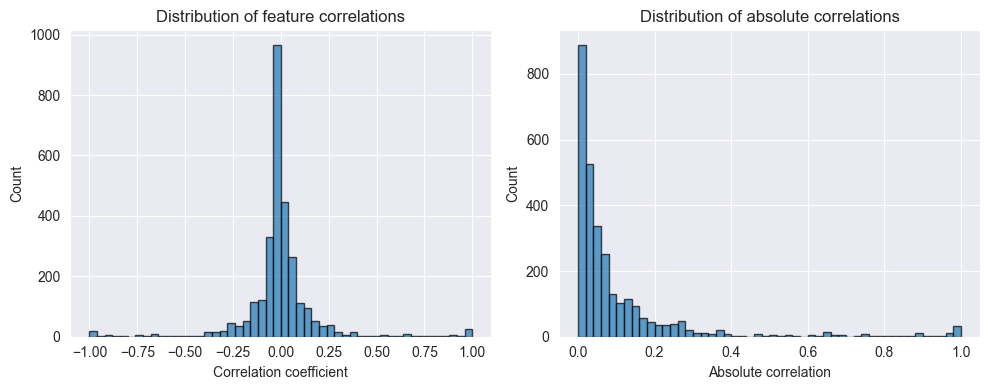

Correlation statistics:
  Mean absolute correlation: 0.103
  High correlations (|r|>0.7): 81
  Moderate correlations (0.3<|r|<0.7): 118
  Low correlations (|r|<0.1): 2134

Found 50 highly correlated feature pairs (|r|>0.9):
  age_at_index... ↔ baseline_age_at_diagnosis...: r=1.000
  sex_at_birth_None... ↔ race_None...: r=1.000
  sex_at_birth_None... ↔ ethnicity_None...: r=1.000
  sex_at_birth_None... ↔ baseline_primary_diagnosis_Gli...: r=-0.971
  sex_at_birth_None... ↔ baseline_primary_diagnosis_Non...: r=1.000
  ... and 45 more

SUMMARY
POTENTIAL ISSUES FOUND:
  - Low variance explained by first 2 PCs (29.6%)

Feature space: 77 dimensions
Patient count: 617
Dimensionality ratio: 8.0 patients/feature


In [117]:
class ClinicalEmbeddingAnalyzer:
    """
    Analyze clinical embeddings for meaningfulness
    """

    def __init__(self, clinical_map_path: str = "data/clinical_map.pkl"):
        with open(clinical_map_path, 'rb') as f:
            data = pickle.load(f)

        self.mapping = data["mapping"]
        self.feature_names = data["feature_names"]
        self.patient_ids = list(self.mapping.keys())
        self.X = np.stack([self.mapping[pid] for pid in self.patient_ids])
        self.n_patients, self.n_features = self.X.shape

        print(f"Loaded {self.n_patients} patients with {self.n_features} features")

    def basic_statistics(self):
        print("=" * 60)
        print("BASIC EMBEDDING STATISTICS")
        print("=" * 60)

        stats_dict = {
            "Shape": f"{self.n_patients} patients × {self.n_features} features",
            "Sparsity (%)": f"{100 * (self.X == 0).sum() / self.X.size:.1f}",
            "NaN values": f"{np.isnan(self.X).sum()}",
            "Mean ± Std": f"{self.X.mean():.3f} ± {self.X.std():.3f}",
            "Min/Max": f"[{self.X.min():.3f}, {self.X.max():.3f}]",
            "Feature correlation (mean)": f"{np.abs(np.corrcoef(self.X.T)).mean():.3f}",
        }

        for key, value in stats_dict.items():
            print(f"{key:30}: {value}")

        feature_stds = self.X.std(axis=0)
        constant_features = np.sum(feature_stds < 1e-10)
        print(f"{'Constant features':30}: {constant_features}")

        if constant_features > 0:
            print(f"Warning: {constant_features} features are constant!")

        # Feature value distribution
        plt.figure(figsize=(12, 4))

        plt.subplot(131)
        plt.hist(self.X.flatten(), bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Feature value')
        plt.ylabel('Frequency')
        plt.title('Overall value distribution')

        plt.subplot(132)
        plt.boxplot(self.X.T)
        plt.ylabel('Feature value')
        plt.title('Feature-wise distributions')

        plt.subplot(133)
        plt.imshow(self.X[:50, :], aspect='auto', cmap='RdBu_r',
                  vmin=-3, vmax=3)
        plt.colorbar(label='Feature value')
        plt.xlabel('Feature index')
        plt.ylabel('Patient index')
        plt.title('First 50 patients (heatmap)')

        plt.tight_layout()
        plt.show()

    def visualize_embeddings(self, survival_data=None):
        """
        Visualize embeddings in 2D/3D using dimensionality reduction

        Args:
            survival_data: Optional dict {patient_id: (time, event)} for coloring
        """
        print("\n" + "=" * 60)
        print("VISUALIZING EMBEDDINGS")
        print("=" * 60)

        # Prepare labels if available
        colors = None
        labels = None

        if survival_data:
            colors = []
            for pid in self.patient_ids:
                if pid in survival_data:
                    time, event = survival_data[pid]
                    colors.append('red' if event == 1 else 'blue')
                else:
                    colors.append('gray')
            colors = np.array(colors)

            # Count events
            events = sum(1 for pid in self.patient_ids
                        if pid in survival_data and survival_data[pid][1] == 1)
            print(f"Survival data: {events} events, {len(colors)-events} censored")

        # Reduce dimensions
        methods = {
            'PCA (2D)': PCA(n_components=2),
            't-SNE': TSNE(n_components=2, perplexity=30, random_state=42),
            'UMAP': umap.UMAP(n_components=2, random_state=42)
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for ax, (name, reducer) in zip(axes, methods.items()):
            try:
                X_reduced = reducer.fit_transform(self.X)

                if colors is not None:
                    # Color by survival status
                    for color in ['red', 'blue', 'gray']:
                        mask = colors == color
                        if mask.any():
                            label = 'Dead' if color == 'red' else \
                                   'Alive' if color == 'blue' else 'Unknown'
                            ax.scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                                     c=color, s=30, alpha=0.6, label=label)
                    ax.legend()
                else:
                    ax.scatter(X_reduced[:, 0], X_reduced[:, 1],
                             c='blue', s=30, alpha=0.6)

                ax.set_title(f'{name}\nVariance: {reducer.explained_variance_ratio_.sum():.2%}'
                           if hasattr(reducer, 'explained_variance_ratio_') else name)
                ax.set_xlabel('Component 1')
                ax.set_ylabel('Component 2')
                ax.grid(True, alpha=0.3)

            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)}',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{name} (Failed)')

        plt.tight_layout()
        plt.show()

        # 3D visualization with PCA
        try:
            pca_3d = PCA(n_components=3)
            X_3d = pca_3d.fit_transform(self.X)

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            if colors is not None:
                for color in ['red', 'blue', 'gray']:
                    mask = colors == color
                    if mask.any():
                        label = 'Dead' if color == 'red' else \
                               'Alive' if color == 'blue' else 'Unknown'
                        ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2],
                                 c=color, s=30, alpha=0.6, label=label)
                ax.legend()
            else:
                ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                         c='blue', s=30, alpha=0.6)

            ax.set_title(f'3D PCA (Total variance: {pca_3d.explained_variance_ratio_.sum():.2%})')
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.set_zlabel('PC3')

            plt.show()
        except Exception as e:
            print(f"3D visualization failed: {e}")

    def cluster_analysis(self):
        print("\n" + "=" * 60)
        print("CLUSTER ANALYSIS")
        print("=" * 60)

        pca = PCA(n_components=min(50, self.n_features))
        X_pca = pca.fit_transform(self.X)

        # Determine optimal number of clusters
        inertias = []
        silhouette_scores = []
        k_range = range(2, min(10, self.n_patients // 10))

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_pca)

            inertias.append(kmeans.inertia_)
            if len(np.unique(labels)) > 1:
                silhouette_scores.append(silhouette_score(X_pca, labels))
            else:
                silhouette_scores.append(0)

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(k_range, inertias, 'bo-')
        axes[0].set_xlabel('Number of clusters')
        axes[0].set_ylabel('Inertia')
        axes[0].set_title('Elbow Method')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(k_range, silhouette_scores, 'ro-')
        axes[1].set_xlabel('Number of clusters')
        axes[1].set_ylabel('Silhouette Score')
        axes[1].set_title('Silhouette Analysis')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Clustering with optimal k
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal clusters (silhouette): {optimal_k}")

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_pca)
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(self.X)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                            c=cluster_labels, cmap='tab10',
                            s=50, alpha=0.6)
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Clusters (t-SNE, k={optimal_k})')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f"\nCluster sizes:")
        unique, counts = np.unique(cluster_labels, return_counts=True)
        for cluster, count in zip(unique, counts):
            print(f"  Cluster {cluster}: {count} patients ({count/self.n_patients:.1%})")

        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(X_pca, cluster_labels)
            calinski_score = calinski_harabasz_score(X_pca, cluster_labels)
            print(f"\nSilhouette score: {silhouette_avg:.3f}")
            print(f"Calinski-Harabasz score: {calinski_score:.1f}")

            if silhouette_avg < 0.2:
                print("Low silhouette score - clusters may not be well separated")
            elif silhouette_avg > 0.5:
                print("Good silhouette score - clusters are reasonably separated")

    def feature_importance_analysis(self, survival_data=None):
        """
        Analyze which features are most important

        Args:
            survival_data: Optional dict {patient_id: (time, event)} for survival analysis
        """
        print("\n" + "=" * 60)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("=" * 60)

        if survival_data is None:
            # Without survival data, use variance as importance
            variances = self.X.var(axis=0)
            top_indices = np.argsort(variances)[-20:][::-1]

            plt.figure(figsize=(12, 6))
            plt.barh(range(20), variances[top_indices])
            plt.yticks(range(20), [self.feature_names[i] for i in top_indices])
            plt.xlabel('Variance')
            plt.title('Top 20 Features by Variance')
            plt.tight_layout()
            plt.show()

            print("Top 10 features by variance:")
            for i in top_indices[:10]:
                print(f"  {self.feature_names[i]}: {variances[i]:.3f}")

        else:
            # With survival data, compute Cox regression-like scores
            from sklearn.feature_selection import f_classif

            # Create binary labels from survival data
            y = np.zeros(self.n_patients)
            for i, pid in enumerate(self.patient_ids):
                if pid in survival_data:
                    _, event = survival_data[pid]
                    y[i] = event

            # Compute ANOVA F-values
            f_values, p_values = f_classif(self.X, y)

            # Plot
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # Top features by F-value
            top_n = min(20, len(f_values))
            top_indices = np.argsort(f_values)[-top_n:][::-1]

            axes[0].barh(range(top_n), f_values[top_indices])
            axes[0].set_yticks(range(top_n))
            axes[0].set_yticklabels([self.feature_names[i] for i in top_indices])
            axes[0].set_xlabel('F-value')
            axes[0].set_title(f'Top {top_n} Features for Survival Prediction')

            # p-value distribution
            significant = p_values < 0.05
            axes[1].hist(p_values, bins=50, alpha=0.7, edgecolor='black')
            axes[1].axvline(0.05, color='red', linestyle='--', label='p=0.05')
            axes[1].set_xlabel('p-value')
            axes[1].set_ylabel('Count')
            axes[1].set_title(f'p-value distribution\n{significant.sum()}/{len(p_values)} significant (p<0.05)')
            axes[1].legend()

            plt.tight_layout()
            plt.show()

            print(f"\nSurvival-related features:")
            print(f"Significant features (p<0.05): {significant.sum()}/{len(p_values)}")
            print("\nTop 10 survival-associated features:")
            for i in top_indices[:10]:
                feat_name = self.feature_names[i]
                if len(feat_name) > 50:
                    feat_name = feat_name[:47] + "..."
                print(f"  {feat_name:50} F={f_values[i]:6.2f}, p={p_values[i]:.2e}")

    def correlation_structure(self):
        """Analyze correlation structure of features"""
        print("\n" + "=" * 60)
        print("CORRELATION STRUCTURE")
        print("=" * 60)

        # Compute correlation matrix
        corr_matrix = np.corrcoef(self.X.T)

        # Plot correlation matrix
        plt.figure(figsize=(12, 10))

        # For large matrices, sample features
        if self.n_features > 50:
            # Select top 50 features by variance
            variances = self.X.var(axis=0)
            top_indices = np.argsort(variances)[-50:][::-1]
            sampled_corr = corr_matrix[top_indices][:, top_indices]
            feature_labels = [self.feature_names[i] for i in top_indices]

            # Truncate long labels
            feature_labels = [lab[:30] + "..." if len(lab) > 30 else lab
                            for lab in feature_labels]
        else:
            sampled_corr = corr_matrix
            feature_labels = self.feature_names

        # Plot heatmap
        sns.heatmap(sampled_corr,
                   cmap='RdBu_r',
                   center=0,
                   square=True,
                   xticklabels=feature_labels,
                   yticklabels=feature_labels)
        plt.title('Feature Correlation Matrix')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Analyze correlation distribution
        upper_tri = np.triu_indices_from(corr_matrix, k=1)
        correlations = corr_matrix[upper_tri]

        plt.figure(figsize=(10, 4))

        plt.subplot(121)
        plt.hist(correlations, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Correlation coefficient')
        plt.ylabel('Count')
        plt.title('Distribution of feature correlations')

        plt.subplot(122)
        plt.hist(np.abs(correlations), bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Absolute correlation')
        plt.ylabel('Count')
        plt.title('Distribution of absolute correlations')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print("Correlation statistics:")
        print(f"  Mean absolute correlation: {np.abs(correlations).mean():.3f}")
        print(f"  High correlations (|r|>0.7): {(np.abs(correlations) > 0.7).sum()}")
        print(f"  Moderate correlations (0.3<|r|<0.7): {((np.abs(correlations) > 0.3) & (np.abs(correlations) < 0.7)).sum()}")
        print(f"  Low correlations (|r|<0.1): {(np.abs(correlations) < 0.1).sum()}")

        # Check for highly correlated features (potential redundancy)
        high_corr_pairs = np.where(np.abs(corr_matrix) > 0.9)
        high_corr_pairs = [(i, j, corr_matrix[i, j])
                          for i, j in zip(*high_corr_pairs)
                          if i < j]

        if high_corr_pairs:
            print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (|r|>0.9):")
            for i, j, corr in high_corr_pairs[:5]:  # Show first 5
                print(f"  {self.feature_names[i][:30]}... ↔ {self.feature_names[j][:30]}...: r={corr:.3f}")
            if len(high_corr_pairs) > 5:
                print(f"  ... and {len(high_corr_pairs)-5} more")
        else:
            print("No highly redundant features (|r|>0.9)")

    def diagnostic_report(self, survival_data=None):
        """
        Run all diagnostics and generate a report
        """
        print("\n" + "=" * 60)
        print("CLINICAL EMBEDDINGS DIAGNOSTIC REPORT")
        print("=" * 60)

        self.basic_statistics()
        self.visualize_embeddings(survival_data)
        self.cluster_analysis()
        self.feature_importance_analysis(survival_data)
        self.correlation_structure()

        print("\n" + "=" * 60)
        print("SUMMARY")
        print("=" * 60)

        # Overall assessment
        issues = []

        # Check 1: Feature count
        if self.n_features < 10:
            issues.append("Low feature count (<10)")
        elif self.n_features > 500:
            issues.append("Very high feature count (>500), consider dimensionality reduction")

        # Check 2: Sparsity
        sparsity = (self.X == 0).sum() / self.X.size
        if sparsity > 0.8:
            issues.append(f"High sparsity ({sparsity:.1%})")

        # Check 3: Variance
        if self.X.std() < 0.1:
            issues.append("Low overall variance")

        # Check 4: Clustering
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X)
        if pca.explained_variance_ratio_.sum() < 0.3:
            issues.append(f"Low variance explained by first 2 PCs ({pca.explained_variance_ratio_.sum():.1%})")

        if issues:
            print("POTENTIAL ISSUES FOUND:")
            for issue in issues:
                print(f"  - {issue}")
        else:
            print("Embeddings look reasonable")

        print(f"\nFeature space: {self.n_features} dimensions")
        print(f"Patient count: {self.n_patients}")
        print(f"Dimensionality ratio: {self.n_patients / self.n_features:.1f} patients/feature")

        if self.n_patients / self.n_features < 5:
            print("Warning: Low patients/feature ratio (<5), risk of overfitting")

        return {
            'n_patients': self.n_patients,
            'n_features': self.n_features,
            'issues': issues,
            'sparsity': sparsity,
            'mean_variance': self.X.var(),
        }


# Example usage with your data
def analyze_my_embeddings():
    """
    Run complete analysis on your clinical embeddings
    """
    # Initialize analyzer
    print("Loading clinical embeddings...")
    analyzer = ClinicalEmbeddingAnalyzer("data/clinical_map.pkl")

    # Load survival labels from separate file
    try:
        with open("data/survival_labels.pkl", "rb") as f:
            survival_data = pickle.load(f)
        print(f"Loaded survival labels: {len(survival_data)} patients")
    except FileNotFoundError:
        print("Warning: survival_labels.pkl not found. Trying to load from clinical_map.pkl...")
        # Fallback: check if labels are in the clinical_map file
        with open("data/clinical_map.pkl", "rb") as f:
            clinical_data = pickle.load(f)

        if "survival_labels" in clinical_data:
            survival_data = clinical_data["survival_labels"]
            print(f"Found survival labels in clinical_map: {len(survival_data)} patients")
        else:
            print("No survival labels found. Analysis will proceed without survival coloring.")
            survival_data = None

    report = analyzer.diagnostic_report(survival_data)
    return report


def quality_check(clinical_map_path: str = "data/clinical_map.pkl"):
    with open(clinical_map_path, 'rb') as f:
        data = pickle.load(f)

    mapping = data["mapping"]
    feature_names = data["feature_names"]

    X = np.stack(list(mapping.values()))

    print("QUICK QUALITY CHECK")
    print("-" * 40)

    checks = []

    checks.append(("Valid matrix", X.shape[0] > 0 and X.shape[1] > 0))
    checks.append(("No NaN values", np.isnan(X).sum() == 0))
    n_features = X.shape[1]
    checks.append((f"Feature count ({n_features})", 10 <= n_features <= 500))
    value_range = X.max() - X.min()
    checks.append((f"Value range ({value_range:.2f})", 0.1 < value_range < 100))
    checks.append(("Feature names", len(feature_names) == n_features and
                  all(isinstance(f, str) for f in feature_names)))

    all_pass = True
    for check_name, passed in checks:
        status = "PASS" if passed else "FAIL"
        print(f"{status}: {check_name}")
        if not passed:
            all_pass = False

    if all_pass:
        print("\nAll checks passed! Embeddings look ready for model integration.")
    else:
        print("\nSome checks failed. Review the embeddings before integration.")

    return all_pass


quality_ok = quality_check("data/clinical_map.pkl")
if quality_ok:
    print("\n\nRunning full diagnostic analysis...")
    report = analyze_my_embeddings()
else:
    print("\nSkipping full analysis due to quality issues.")

In [118]:
def check_pca_variance_cumulative(analyzer):
    from sklearn.decomposition import PCA

    X = analyzer.X
    pca_full = PCA()
    pca_full.fit(X)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    pc_80 = np.argmax(cumulative_variance >= 0.80) + 1
    pc_90 = np.argmax(cumulative_variance >= 0.90) + 1
    pc_95 = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-o')
    plt.axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='80% variance')
    plt.axhline(y=0.90, color='g', linestyle='--', alpha=0.7, label='90% variance')
    plt.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% variance')

    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: How many dimensions explain most variance?')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.text(pc_80, 0.80, f'{pc_80} PCs', ha='left', va='bottom')
    plt.text(pc_90, 0.90, f'{pc_90} PCs', ha='left', va='bottom')
    plt.text(pc_95, 0.95, f'{pc_95} PCs', ha='left', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"PCA Variance Analysis:")
    print(f"   First 2 PCs explain: {cumulative_variance[1]:.1%} variance")
    print(f"   Need {pc_80} PCs to explain 80% variance")
    print(f"   Need {pc_90} PCs to explain 90% variance")
    print(f"   Need {pc_95} PCs to explain 95% variance")

    intrinsic_dimensionality = pc_95
    total_features = X.shape[1]

    print(f"\nInterpretation:")
    print(f"   Your data has {total_features} features")
    print(f"   Only {intrinsic_dimensionality} are needed for 95% information")
    print(f"   Dimensionality reduction ratio: {intrinsic_dimensionality/total_features:.1%}")

    if intrinsic_dimensionality/total_features < 0.3:
        print("Efficient encoding: You're capturing information efficiently!")
    else:
        print("Consider feature selection/compression for efficiency")

    return cumulative_variance

In [119]:
def clinical_specific_checks(analyzer):
    """
    More relevant checks for clinical embeddings
    """
    X = analyzer.X
    feature_names = analyzer.feature_names

    print("\n" + "=" * 60)
    print("CLINICAL-SPECIFIC QUALITY CHECKS")
    print("=" * 60)

    clinical_categories = {
        'demographic': ['age', 'sex', 'race', 'ethnicity'],
        'diagnosis': ['diagnosis', 'morphology', 'icd', 'classification'],
        'treatment': ['surgery', 'radiation', 'chemo', 'dexamethasone'],
        'outcome': ['survival', 'progression', 'kps', 'vital'],
        'temporal': ['days_to', 'first_', 'time']
    }

    print("\n1. Feature Category Distribution:")
    for category, keywords in clinical_categories.items():
        count = sum(any(keyword in name.lower() for keyword in keywords)
                   for name in feature_names)
        print(f"   {category.title():15}: {count:3d} features")

    print("\n2. Feature Value Ranges (sample of 10 features):")
    for i in np.random.choice(len(feature_names), 10, replace=False):
        feat = X[:, i]
        name = feature_names[i]
        if len(name) > 30:
            name = name[:27] + "..."
        print(f"   {name:30}: [{feat.min():7.3f}, {feat.max():7.3f}] mean={feat.mean():7.3f}")

    print("\n3. Patient-level Statistics:")
    patient_means = X.mean(axis=1)
    patient_stds = X.std(axis=1)
    print(f"   Mean feature value per patient: {patient_means.mean():.3f} ± {patient_means.std():.3f}")
    print(f"   Feature std per patient: {patient_stds.mean():.3f} ± {patient_stds.std():.3f}")

    return True

def check_for_model_readiness(analyzer):
    X = analyzer.X
    n_patients, n_features = X.shape

    print("\n" + "=" * 60)
    print("MODEL READINESS CHECKLIST")
    print("=" * 60)

    checklist = []

    patients_per_feature = n_patients / n_features
    checklist.append({
        'item': f"Patients/feature ratio ({patients_per_feature:.1f})",
        'status': patients_per_feature >= 5,
        'message': '≥5 is good, <2 risks overfitting' if patients_per_feature < 2 else 'Good!'
    })

    has_nan = np.isnan(X).any()
    checklist.append({
        'item': "No NaN values",
        'status': not has_nan,
        'message': 'All values are numerical' if not has_nan else 'Contains NaN - needs imputation'
    })

    data_range = X.max() - X.min()
    checklist.append({
        'item': f"Feature scale ({data_range:.1f} range)",
        'status': 0.1 < data_range < 100,
        'message': f'Range {data_range:.1f} is appropriate' if 0.1 < data_range < 100 else 'Consider rescaling'
    })

    sparsity = (X == 0).sum() / X.size
    checklist.append({
        'item': f"Feature sparsity ({sparsity:.1%})",
        'status': sparsity < 0.9,
        'message': 'Reasonable information density' if sparsity < 0.9 else 'Very sparse - might need different encoding'
    })

    feature_vars = X.var(axis=0)
    low_var_features = (feature_vars < 0.01).sum()
    checklist.append({
        'item': f"Low-variance features ({low_var_features})",
        'status': low_var_features / n_features < 0.1,
        'message': f'{low_var_features} features with <0.01 variance' if low_var_features > 0 else 'All features have reasonable variance'
    })

    print("\nChecklist Results:")
    print("-" * 40)

    all_good = True
    for check in checklist:
        status = "PASS" if check['status'] else "FAIL"
        print(f"{status} - {check['item']}")
        print(f"     Note: {check['message']}")
        if not check['status']:
            all_good = False

    print("\n" + "=" * 60)
    if all_good:
        print("Embeddings are ready to be integrated.")
    else:
        print("Some issues need attention before integration.")

    return all_good

Loaded 617 patients with 77 features


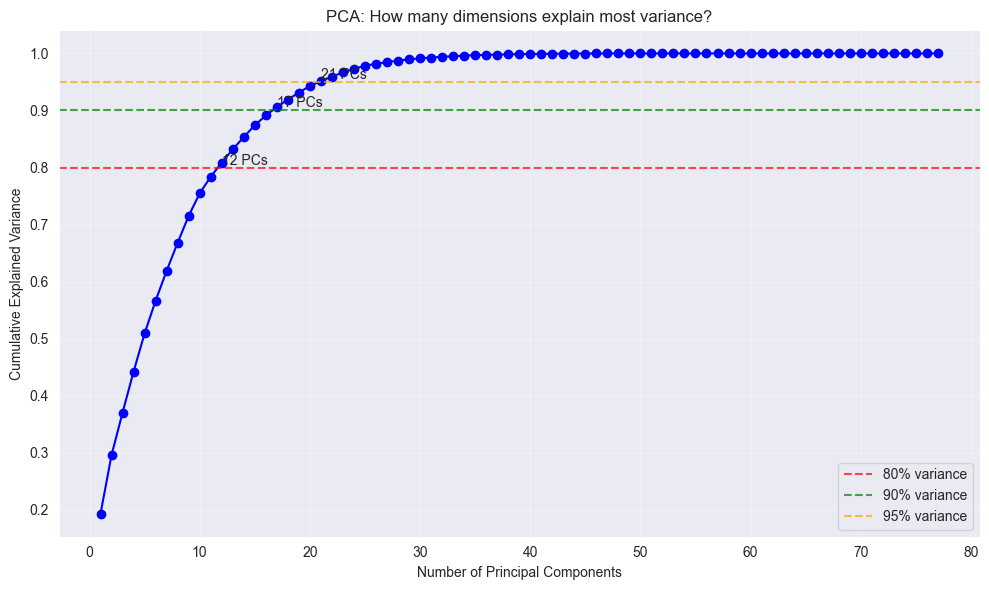

PCA Variance Analysis:
   First 2 PCs explain: 29.6% variance
   Need 12 PCs to explain 80% variance
   Need 17 PCs to explain 90% variance
   Need 21 PCs to explain 95% variance

Interpretation:
   Your data has 77 features
   Only 21 are needed for 95% information
   Dimensionality reduction ratio: 27.3%
Efficient encoding: You're capturing information efficiently!

CLINICAL-SPECIFIC QUALITY CHECKS

1. Feature Category Distribution:
   Demographic    :  15 features
   Diagnosis      :  17 features
   Treatment      :  13 features
   Outcome        :  31 features
   Temporal       :   9 features

2. Feature Value Ranges (sample of 10 features):
   baseline_classification_not...: [  0.000,   1.000] mean=  0.006
   kps_min_100.0                 : [  0.000,   1.000] mean=  0.096
   days_to_first_surgery         : [-15.438,   7.681] mean= -0.000
   ethnicity_not hispanic or l...: [  0.000,   1.000] mean=  0.794
   baseline_icd10_C71.9          : [  0.000,   1.000] mean=  0.951
   baseline

In [120]:
analyzer = ClinicalEmbeddingAnalyzer("data/clinical_map.pkl")
check_pca_variance_cumulative(analyzer)
clinical_specific_checks(analyzer)
is_ready = check_for_model_readiness(analyzer)

In [121]:
def remove_low_variance_features(clinical_map_path: str = "data/clinical_map.pkl",
                                 variance_threshold: float = 0.01,
                                 output_path: str = "data/clinical_map_filtered.pkl"):
    """
    Remove low-variance features from clinical embeddings

    Args:
        variance_threshold: Minimum variance to keep a feature (default 0.01)
        output_path: Where to save the filtered embeddings
    """
    import pickle
    import numpy as np

    with open(clinical_map_path, 'rb') as f:
        data = pickle.load(f)

    mapping = data["mapping"]
    feature_names = data["feature_names"]
    patient_ids = list(mapping.keys())
    X = np.stack([mapping[pid] for pid in patient_ids])
    variances = X.var(axis=0)

    # Identify low-variance features
    low_var_mask = variances < variance_threshold
    low_var_indices = np.where(low_var_mask)[0]

    print(f"Original: {X.shape[1]} features")
    print(f"Low-variance features (<{variance_threshold}): {low_var_mask.sum()}")

    if low_var_mask.sum() > 0:
        print("\nLow-variance features to remove:")
        for idx in low_var_indices:
            name = feature_names[idx]
            var = variances[idx]
            if len(name) > 50:
                name = name[:47] + "..."
            print(f"  {name:50} variance={var:.6f}")

    # Keep only high-variance features
    high_var_mask = ~low_var_mask
    X_filtered = X[:, high_var_mask]
    feature_names_filtered = [feature_names[i] for i in range(len(feature_names))
                             if high_var_mask[i]]

    mapping_filtered = {}
    for i, pid in enumerate(patient_ids):
        mapping_filtered[pid] = X_filtered[i]

    print(f"\nFiltered: {X_filtered.shape[1]} features")
    print(f"Removed: {low_var_mask.sum()} features ({low_var_mask.sum()/X.shape[1]:.1%})")

    with open(output_path, 'wb') as f:
        pickle.dump({
            "mapping": mapping_filtered,
            "feature_names": feature_names_filtered,
            "patient_ids": patient_ids,
            "n_features": X_filtered.shape[1],
            "removed_features": [feature_names[i] for i in low_var_indices] if low_var_indices.size > 0 else [],
            "variance_threshold": variance_threshold
        }, f)

    print(f"\nSaved filtered embeddings to: {output_path}")
    return mapping_filtered, feature_names_filtered

mapping_filtered, features_filtered = remove_low_variance_features()

Original: 77 features
Low-variance features (<0.01): 14

Low-variance features to remove:
  sex_at_birth_unknown                               variance=0.006441
  baseline_primary_diagnosis_Not Reported            variance=0.001618
  baseline_morphology_Not Reported                   variance=0.001618
  baseline_icd10_C71.1                               variance=0.004839
  baseline_icd10_C71.2                               variance=0.004839
  baseline_icd10_C71.4                               variance=0.003231
  baseline_icd10_C71.8                               variance=0.001618
  baseline_classification_not reported               variance=0.006441
  num_progression_diagnoses_3                        variance=0.006441
  kps_min_0.0                                        variance=0.004839
  kps_min_20.0                                       variance=0.003231
  kps_min_50.0                                       variance=0.003231
  kps_max_0.0                                        varia

In [122]:
# Verification
analyzer_fixed = ClinicalEmbeddingAnalyzer("data/clinical_map_filtered.pkl")
is_ready = check_for_model_readiness(analyzer_fixed)

Loaded 617 patients with 63 features

MODEL READINESS CHECKLIST

Checklist Results:
----------------------------------------
PASS - Patients/feature ratio (9.8)
     Note: Good!
PASS - No NaN values
     Note: All values are numerical
PASS - Feature scale (39.2 range)
     Note: Range 39.2 is appropriate
PASS - Feature sparsity (52.5%)
     Note: Reasonable information density
PASS - Low-variance features (0)
     Note: All features have reasonable variance

Embeddings are ready to be integrated.
